# Imports

In [1]:
!pip install transformers

In [2]:
import os
import h5py
import json
import numpy as np
from transformers import DistilBertTokenizer, TFDistilBertModel
import cv2
from sklearn.model_selection import train_test_split

import keras as keras
from keras.models import Model
from keras import layers as layers
from keras.initializers import glorot_uniform
from keras import backend as K
K.set_image_data_format('channels_last')
import tensorflow as tf
from tensorflow.keras.utils import to_categorical, plot_model

import nltk
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')
from nltk.stem.snowball import SnowballStemmer

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Reading data

In [3]:
# from google.colab import drive
# drive.mount('/content/gdrive/', force_remount=True)
# base_path = '/content/gdrive/My Drive/iust/miniVQA/'
# output_path = base_path
base_path = '/kaggle/input/medical-visual-question-answering/'
image_path = base_path + '/VQA_RAD Image Folder'
output_path = '/kaggle/working/'

In [7]:
with open(base_path + "/VQA_RAD Dataset Public.json", "r") as f:
    rad_json_data = json.load(f)
rad_json_data = [d for d in rad_json_data if d["answer_type"] == "CLOSED"]

In [11]:
print(rad_json_data[0])

{'qid': '0', 'phrase_type': 'freeform', 'qid_linked_id': '03f451ca-de62-4617-9679-e836026a7642', 'image_case_url': 'https://medpix.nlm.nih.gov/case?id=48e1dd0e-8552-46ad-a354-5eb55be86de6', 'image_name': 'synpic54610.jpg', 'image_organ': 'HEAD', 'evaluation': 'not evaluated', 'question': 'Are regions of the brain infarcted?', 'question_rephrase': 'NULL', 'question_relation': 'NULL', 'question_frame': 'NULL', 'question_type': 'PRES', 'answer': 'Yes', 'answer_type': 'CLOSED'}


In [9]:
print(len(rad_json_data))

1297


## Dataset Structure
* qid: question id
* phrase_type: freeform / para / test-freeform / test-paraphrase
* qid_linked_id: unique identifier for every pair of free-form and paraphrased questions that can be used to link original and rephrasing
* image_case_url: image url in medpix
* image_name
* image_organ (e.g. HEAD)
* evaluation: evaluated = two clinical annotators reviewed image and QA pair, not evaluated = one clinical annotator
* question
* question_rephrase: rephrasing of ‘question’, can be freeform or para, linked through qid_linked_id
* question_relation: rephrasing of ‘question’ following a templated structure
* question_type: MODALITY - PLANE - ORGAN (Organ System) - ABN (Abnormality) - PRES (Object/Condition Presence) - POS (Positional Reasoning) - COLOR - SIZE - ATTRIB (Attribute Other) - COUNT (Counting) - Other
* answer
* answer_type (e.g. CLOSED)

# Data Generator

In [12]:
max_length = 10
batch_size = 64
# Tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

In [13]:
def load_images_from_list(pixel_x, pixel_y, img_names, folder_path=image_path):
    images_list = []

    for img in img_names:
        img_path = folder_path + "/" + img
        image = cv2.imread(img_path, 0)
        image = cv2.resize(
            image, (pixel_y, pixel_x), interpolation=cv2.INTER_AREA
        )  # resize image
        images_list.append(image)

    images_list_np = np.array(images_list)
    return images_list_np

In [15]:
vocab = set([q["answer"].lower() for q in rad_json_data])
wtoi = {w:i for i,w in enumerate(vocab)}

In [17]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, json_data, batch_size):
        self.json_data = json_data
        self.batch_size = batch_size
        

    def __len__(self):
        return (np.ceil(len(self.json_data) / float(self.batch_size))).astype(int)
    
    def preprocess_text(self, texts):
        tokens = tokenizer(texts, max_length=max_length, 
                               truncation=True ,padding='max_length', return_tensors="pt")
        return tokens.input_ids

    def __getitem__(self, idx):
        batch_data = self.json_data[
            idx * self.batch_size : (idx + 1) * self.batch_size
        ]
        batch_image_names = [d["image_name"] for d in batch_data]
        batch_images = load_images_from_list(224, 224, batch_image_names)
        batch_images = np.expand_dims(batch_images, axis=-1)
        batch_images = tf.image.grayscale_to_rgb(tf.convert_to_tensor(batch_images), name=None)
        
        batch_questions = self.preprocess_text(
            [d["question"] for d in batch_data]
        )
        
        batch_y = to_categorical(
            np.array([wtoi[data["answer"].lower()] for data in batch_data]),
            num_classes=len(vocab),
            dtype ="uint8"
        )
        return [batch_questions, batch_images], batch_y


In [20]:
train_json_data, valid_json_data = train_test_split(rad_json_data, test_size=0.1, random_state=42)

In [24]:
train_datagen = DataGenerator(train_json_data, batch_size)
valid_datagen = DataGenerator(valid_json_data, batch_size)

# Model

## MFB Block

In [74]:
class MFBBlock(layers.Layer):
    def __init__(self, drop_out_rate=0.5, factor_num=10, out_dim=10, **kwargs):
        self.drop_out_rate = drop_out_rate
        self.factor_num = factor_num
        self.out_dim = out_dim
        super(MFBBlock, self).__init__(**kwargs)

    def build(self, input_shape):
        super(MFBBlock, self).build(input_shape)

    def call(self, inputs):
        x, y = inputs
        # EXPAND
        exp1 = layers.Multiply()([x, y])
        exp2 = layers.Dropout(self.drop_out_rate)(exp1)

        reshape1 = layers.Reshape((-1, self.out_dim, self.factor_num))(exp2)
        
        # SQUEEZE
        sq1 = layers.AveragePooling2D(pool_size=self.factor_num, strides=self.factor_num)(reshape1)
        reshape2 = layers.Reshape((-1,))(sq1)
        # power normalization
        sq2 = layers.Lambda(lambda x: K.sign(x) * K.sqrt(K.abs(x)))(reshape2)
        # l2 normalization
        sq3 = layers.Lambda(lambda x: K.l2_normalize(x, axis=-1))(sq2)
        return sq3

## Resnet50

In [75]:
resnet50 = tf.keras.applications.ResNet50(
        include_top=False,
        weights="imagenet",
        input_shape=(224, 224, 3),
    )

## DistilBert

In [76]:
distilbert = TFDistilBertModel.from_pretrained('distilbert-base-uncased')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


## Complete modal

In [77]:
def get_vqa_model(q_input_shape, img_input_shape, max_length,
                  classes_n, img_feat_len = 1000, activation_function = 'tanh'):
  
    resnet50trainable = False

    distilbert.trainable = False

    q_input = layers.Input(shape=(max_length,), dtype=tf.int32, name='input_ids')
    distilbert_output = distilbert(q_input)[0]
    q_feat = layers.Reshape((-1,))(distilbert_output)
    q_feat = layers.Dense(img_feat_len, kernel_initializer=glorot_uniform(seed=0))(q_feat)
    q_feat = layers.Dropout(0.5)(q_feat)

    img_input = layers.Input((224, 224, 3), dtype='float32')
    resnet_outout = resnet50(img_input)
    resnet_outout = layers.Reshape((-1,))(resnet_outout)
    img_feat = layers.Dense(img_feat_len, kernel_initializer=glorot_uniform(seed=0))(resnet_outout)
    img_feat = layers.Dropout(0.5)(img_feat)
    
    x = MFBBlock()([q_feat, img_feat])
       
    x = layers.Dense(classes_n)(x)    
    x = layers.Activation('softmax')(x)
    model = Model(inputs=[q_input, img_input], outputs=x)
    
    return model

In [78]:
vqa_model = get_vqa_model((10, 768,), (1000,), max_length=max_length, classes_n=len(vocab))

# Compile

In [79]:
learning_rate = 3e-4

In [80]:
vqa_model.compile(loss='categorical_crossentropy',
                  optimizer=tf.keras.optimizers.RMSprop(learning_rate=learning_rate), metrics=['accuracy'])

# Train

In [81]:
histories = []
epochs = 20

In [82]:
history = vqa_model.fit(
    x=train_datagen, 
    validation_data=valid_datagen,
    epochs=epochs,
    verbose=1
    )
histories.append(history)

Epoch 1/20
19/19 [==============================] - 53s 948ms/step - loss: 3.8173 - accuracy: 0.3736 - val_loss: 3.7855 - val_accuracy: 0.5308
Epoch 2/20
19/19 [==============================] - 15s 774ms/step - loss: 3.7380 - accuracy: 0.5904 - val_loss: 3.7480 - val_accuracy: 0.5154
Epoch 3/20
19/19 [==============================] - 15s 789ms/step - loss: 3.6928 - accuracy: 0.6041 - val_loss: 3.7129 - val_accuracy: 0.5769
Epoch 4/20
19/19 [==============================] - 15s 782ms/step - loss: 3.6489 - accuracy: 0.6838 - val_loss: 3.6771 - val_accuracy: 0.5538
Epoch 5/20
19/19 [==============================] - 15s 785ms/step - loss: 3.6064 - accuracy: 0.7155 - val_loss: 3.6378 - val_accuracy: 0.5692
Epoch 6/20
19/19 [==============================] - 15s 775ms/step - loss: 3.5668 - accuracy: 0.7266 - val_loss: 3.6097 - val_accuracy: 0.5615
Epoch 7/20
19/19 [==============================] - 15s 777ms/step - loss: 3.5300 - accuracy: 0.7352 - val_loss: 3.5762 - val_accuracy: 0.6154

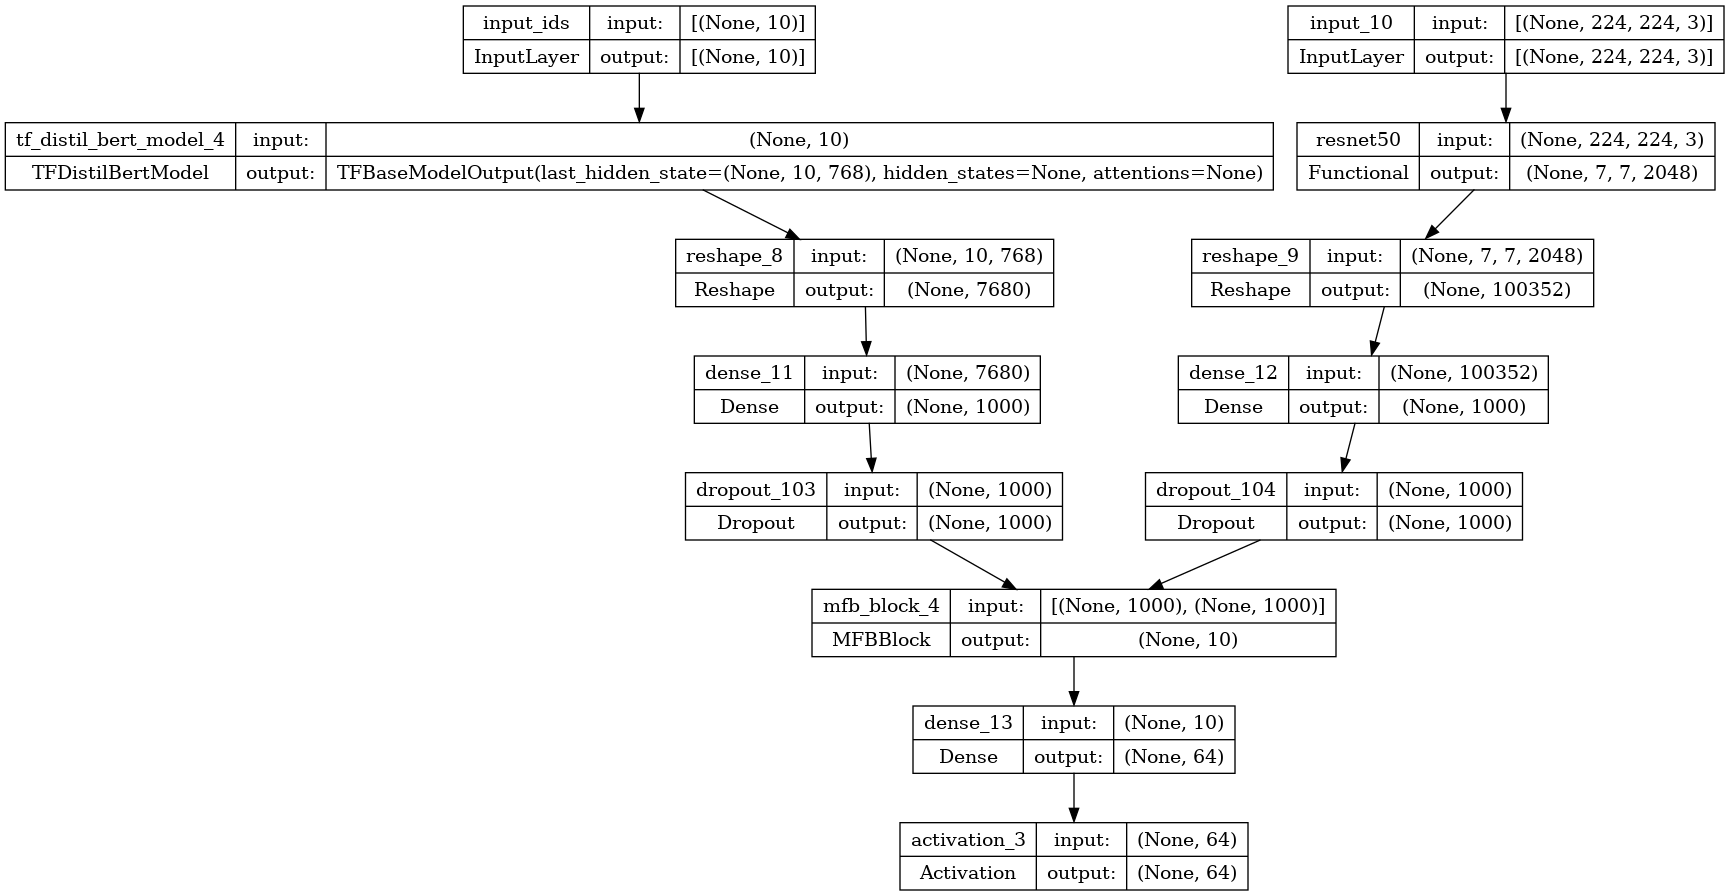

In [83]:
plot_model(vqa_model, show_shapes=True)

In [84]:
combined_history = {}

for key in histories[0].history.keys():
    combined_history[key] = []
    for history in histories:
        combined_history[key] += history.history[key]


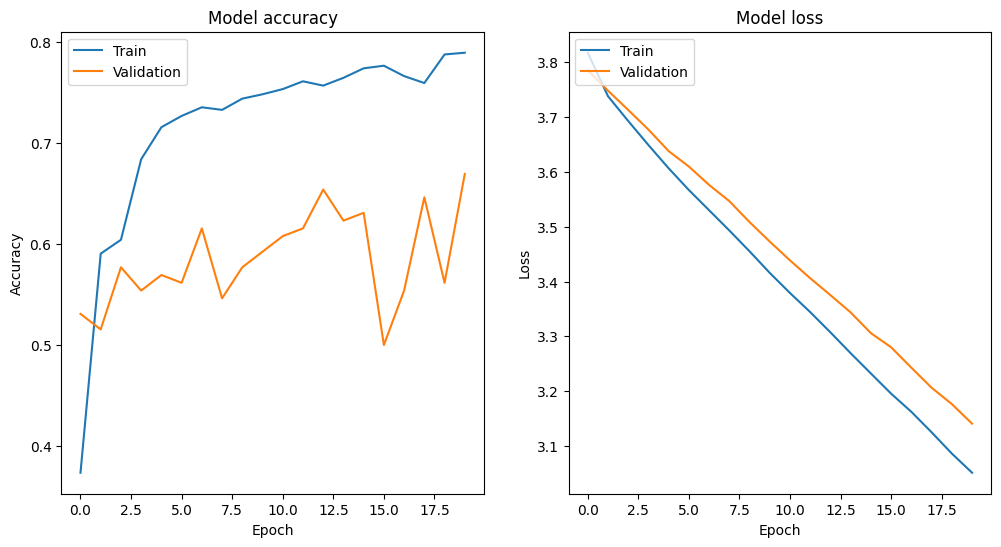

In [85]:
import matplotlib.pyplot as plt

def plot_combined_history(history):
    plt.figure(figsize=(12, 6))

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 1)
    plt.plot(history['accuracy'])
    plt.plot(history['val_accuracy'])
    plt.title('Model accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('Model loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.show()

# Call the function with the combined history
plot_combined_history(combined_history)